In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/RestaurantVisitors.csv', index_col=0, parse_dates=True)

In [3]:
df.index.freq='D'

In [4]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [5]:
def replace_day(col):
    for i in df['weekday'].unique()[1:3]:
        if i in col:
            return 1
    else:
        return 0

In [6]:
df['weekend'] = df['weekday'].apply(replace_day)

In [7]:
df = df[['holiday', 'weekend', 'total']]

In [8]:
df.head()

,holiday,weekend,total
date,,,
2016-01-01,1,0,296.0
2016-01-02,0,1,191.0
2016-01-03,0,1,202.0
2016-01-04,0,0,105.0
2016-01-05,0,0,98.0


In [9]:
len(df)

517

In [11]:
len(df.dropna())

478

In [14]:
df1 = df.iloc[:478]

In [16]:
df2 = df.iloc[478:]

In [17]:
# EDA

In [24]:
df1['total']=df1['total'].astype('int')

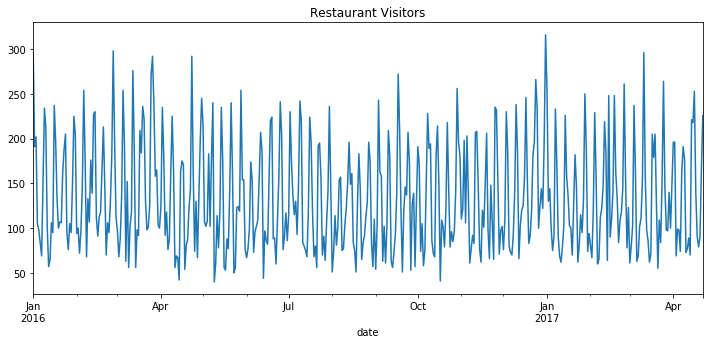

In [25]:
df1['total'].plot()
plt.title('Restaurant Visitors');

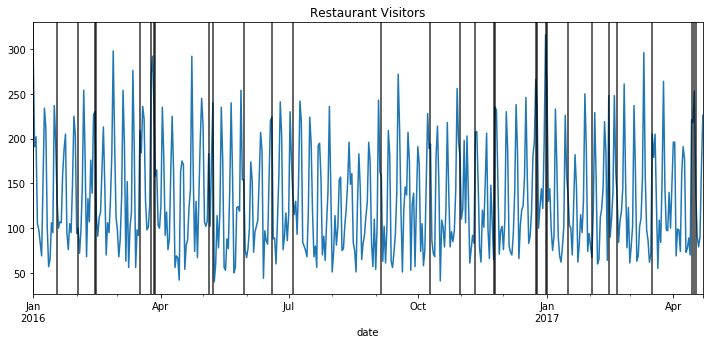

In [62]:
# Look AT the holidays
ax = df1['total'].plot()
plt.title('Restaurant Visitors');
for day in df1[df1['holiday']==1].index:
    ax.axvline(x=day, color='black', alpha=0.8)

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

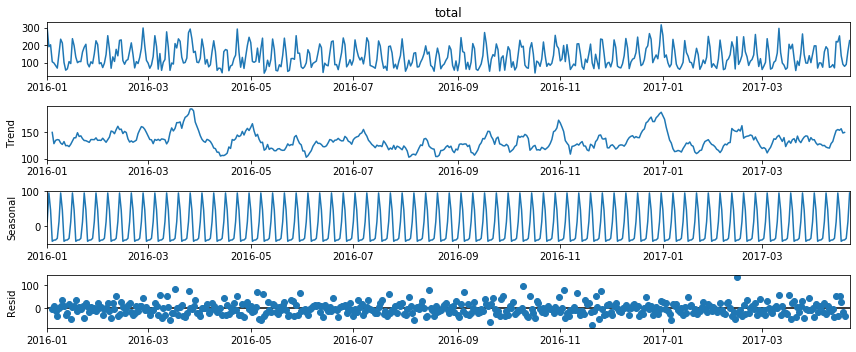

In [27]:
seasonal_decompose(df1['total']).plot();

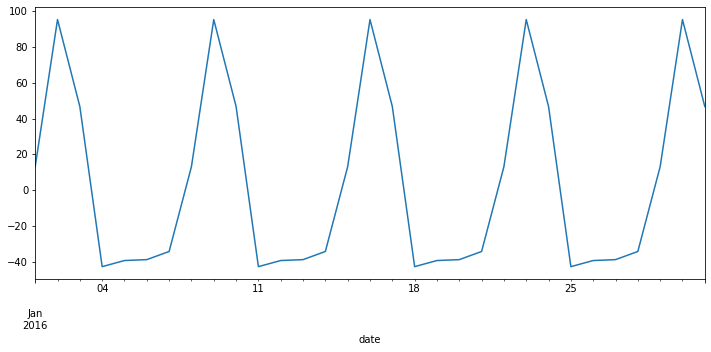

In [33]:
seasonal_decompose(df1['total']).seasonal.loc['2016-1-1':'2016-1-31'].plot();
# weekly data
# m=7

In [38]:
# Stationarity Test

In [39]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [40]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [41]:
# AUTOMARIMA

In [42]:
from pmdarima import auto_arima

In [43]:
auto_arima(df1['total'], exogenous=df1[['holiday', 'weekend']], start_p=0, start_q=0, seasonal=True, m=7, trace=True).summary()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 7); AIC=4594.693, BIC=4619.711, Fit time=1.060 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=4790.389, BIC=4807.068, Fit time=0.155 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=4733.583, BIC=4758.601, Fit time=0.778 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=4712.012, BIC=4737.030, Fit time=0.857 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 7); AIC=4729.696, BIC=4750.544, Fit time=0.577 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=4741.634, BIC=4770.821, Fit time=1.738 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=4693.397, BIC=4714.245, Fit time=0.771 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 7); AIC=4641.944, BIC=4671.131, Fit time=1.416 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 2, 7); AIC=4603.451, BIC=4636.808, Fit time=1.717 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2279.304
Date:                           Sat, 04 Jul 2020   AIC                           4572.607
Time:                                   13:01:24   BIC                           4601.795
Sample:                                        0   HQIC                          4584.082
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6198      0.537      1.155      0.248      -0.432       1.672
x1            81.7459      3.882     21.060      0.000      74.138      89.354
x2           133.0863     18.099      7.353      0.000      97.612     168.560
ma.L1          0.1580      0.047      3.387      0.001       0.067       0.249
ar.S.L7        0.9930      0.006    173.861      0.000       0.982       1.004
ma.S.L7       -0.9200      0.030    -31.105      0.000      -0.978      -0.862
sigma2       788.6405     45.924     17.173      0.000     698.631     878.650
===================================================================================
Ljung-Box (Q):                       36.84   Jarque-Bera (JB):                39.55
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.25
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Train test Split

In [46]:
len(df1)

478

In [56]:
train = df1.iloc[:425]

In [55]:
test = df1.iloc[425:]

# MODEL

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
model = SARIMAX(train['total'],exog=train[['holiday', 'weekend']], order=(0,0,1), seasonal_order=(1,0,1,7)).fit()

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  425
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2034.289
Date:                           Sat, 04 Jul 2020   AIC                           4080.578
Time:                                   13:06:27   BIC                           4104.891
Sample:                               01-01-2016   HQIC                          4090.183
                                    - 02-28-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       69.7177      3.863     18.046      0.000      62.146      77.290
weekend      194.6184    107.727      1.807      0.071     -16.522     405.759
ma.L1          0.1931      0.048      4.048      0.000       0.100       0.287
ar.S.L7        0.9998      0.000   5601.808      0.000       0.999       1.000
ma.S.L7       -0.9446      0.023    -40.742      0.000      -0.990      -0.899
sigma2       784.0681     46.024     17.036      0.000     693.862     874.274
===================================================================================
Ljung-Box (Q):                       39.11   Jarque-Bera (JB):                22.77
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.25
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
predictions = model.predict(start=len(train), end=len(train) + len(test) -1,exog=test[['holiday', 'weekend']]).rename('SARIMA(X) Predictions')

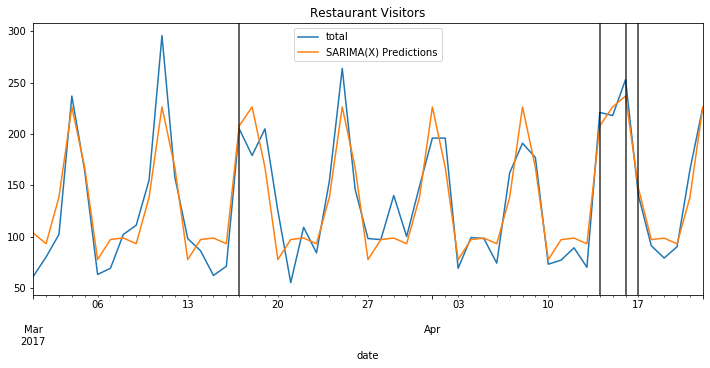

In [63]:
ax=test['total'].plot()
predictions.plot()
plt.legend()
plt.title('Restaurant Visitors')
for day in test[test['holiday']==1].index:
    ax.axvline(x=day, color='black', alpha=0.8)

In [64]:
from statsmodels.tools.eval_measures import rmse

In [65]:
print('RMSE: {}'.format(rmse(test['total'], predictions)))

RMSE: 24.362853180898004


# Retrain the model on the full data, and forecast the future

In [66]:
model = SARIMAX(df1['total'],exog=df1[['holiday', 'weekend']], order=(0,0,1), seasonal_order=(1,0,1,7)).fit()

In [71]:
forecast = model.predict(start=len(df1), end=len(df)-1, exog=df2[['holiday', 'weekend']]).rename('SARIMA(X) Forecast')

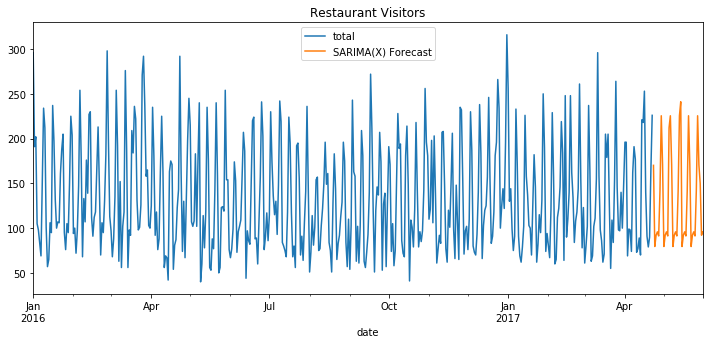

In [76]:
df1['total'].plot()
forecast.plot()
plt.legend()
plt.title('Restaurant Visitors');

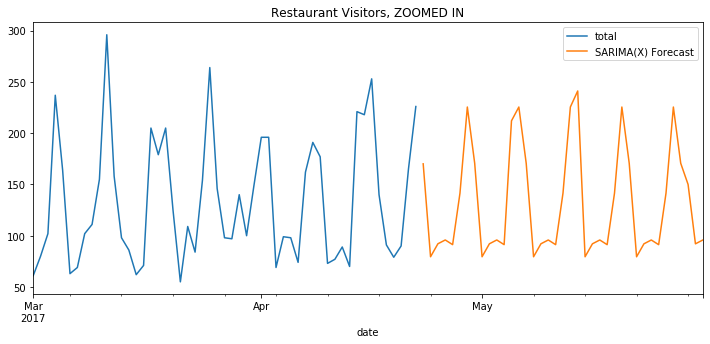

In [77]:
df1['total'].loc['2017-3-1':].plot()
forecast.plot()
plt.legend()
plt.title('Restaurant Visitors, ZOOMED IN');